Here I will try and prove that my model isn't working. First, I will run my optimizer 3 times to see if I get different results.

Now I will compare how the mode matching compares to actually tracing the particle. I will also inspect these swarms to see that they make sense.




In [1]:
from latticeKnobOptimizer import LatticeOptimizer
import dill
import matplotlib.pyplot as plt
from ParticleClass import Swarm,Particle
from ParticleTracerLatticeClass import ParticleTracerLattice
import numpy as np
import time
from SwarmTracerClass import SwarmTracer
from optimizerHelperFunctions import generate_Ring_Lattice,generate_Injector_Lattice
parallel=False

# ----------Solution-----------
# injector element spacing optimum configuration: [0.11652682 0.15987338]
# storage ring tuned params 1 optimum configuration: [0.01735615 0.01862932 0.01045384 0.23310078]
# storage ring tuned params 2 optimum configuration: [0.74855618 0.23266489]
# cost: 0.7128687387339413
# survival: 30.08483898135802

XRing= [0.01735615 ,0.01862932 ,0.01045384 ,0.23310078]
rpLens,rpLensFirst,Lm,LLens=XRing

PTL_Ring=generate_Ring_Lattice(rpLens,rpLensFirst,Lm,LLens)
PTL_Injector=generate_Injector_Lattice()

XLatticeSpace= [0.74855618, 0.23266489]
XInjectorSpace= [0.11652682 ,0.15987338]




# file=open('ringFile','wb')
# dill.dump(PTL_Ring,file)
# file=open('ringFile','rb')
# PTL_Ring=dill.load(file)



optimizer=LatticeOptimizer(PTL_Ring,PTL_Injector)
# optimizer.numParticlesRing=50000
# optimizer.numParticlesInjector=1000
elementIndices=(1,7)
ringTuningBounds = [(.2, .8), (.2, .8)]
injectorTuningBounds = [(.05, .4), (.05, .4)]
optimizer.catch_Optimizer_Errors(ringTuningBounds, elementIndices, 'spacing')
optimizer.initialize_Optimizer(elementIndices,'spacing',ringTuningBounds,injectorTuningBounds)
optimizer.update_Ring_Lattice(XLatticeSpace)
optimizer.update_Injector_Lattice(XInjectorSpace)

# file=open('ringFile','wb')
# dill.dump(PTL_Ring,file)



298


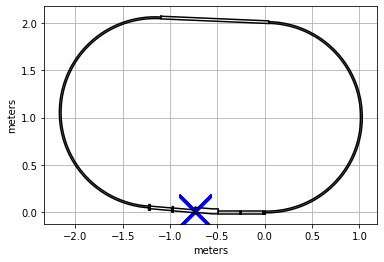

In [2]:
#trace through injector
fastMode=True
h=5e-6
swarm=optimizer.swarmInjectorInitial
# swarm=Swarm()
# swarm.add_Particle()
swarmInjectorTraced = optimizer.swarmTracerInjector.trace_Swarm_Through_Lattice(
    swarm
    , h, 1.0, parallel=False,
    fastMode=fastMode, copySwarm=True,
    accelerated=True)
print(swarmInjectorTraced.num_Particles())
swarmEnd = optimizer.move_Survived_Particles_In_Injector_Swarm_To_Origin(swarmInjectorTraced, copyParticles=False)
# print(swarmEnd.num_Particles())
swarmRingInitial = optimizer.swarmTracerRing.move_Swarm_To_Combiner_Output(swarmEnd, copySwarm=False,scoot=True)
optimizer.latticeRing.show_Lattice(swarm=swarmRingInitial,trueAspectRatio=True,showTraceLines=True,traceLineAlpha=.25,showMarkers=True,finalCoords=False,showRelativeSurvival=False) #careful about which swarm!

In [3]:
#trace through lattice
import multiprocess as mp
def params(T):
    fastMode=True
    optimizer.T=T
    swarmTraced = optimizer.swarmTracerRing.trace_Swarm_Through_Lattice(swarmRingInitial, optimizer.h, optimizer.T, parallel=False,
                                                                        fastMode=fastMode, accelerated=True, copySwarm=True)
    # PTL_Ring.show_Lattice(swarm=swarmTraced,showMarkers=False,showTraceLines=True,traceLineAlpha=.5)
    return swarmTraced.weighted_Flux_Multiplication(),optimizer.maximum_Weighted_Flux_Multiplication()
TArr=np.logspace(np.log10(1),np.log10(100),30)
# with mp.Pool(10) as pool:
#     results=np.asarray(pool.map(params,TArr))

In [4]:
# flux=results[:,0]
# fluxMax=results[:,1]
# plt.scatter(TArr,flux/fluxMax)
# plt.show()
# plt.scatter(TArr,flux)
# plt.show()

# look at energy conservation

In [11]:
swarmETest=Swarm()
swarmETest.particles=swarmRingInitial.particles[:11]
def trace_ETest_Swarm(T):
    optimizer.T=T
    swarmTraced = optimizer.swarmTracerRing.trace_Swarm_Through_Lattice(swarmETest, optimizer.h, optimizer.T, parallel=True,
                                                                    fastMode=False, accelerated=True, copySwarm=True)
    return swarmTraced
t=time.time()
swarmTraced=trace_ETest_Swarm(10)
print(time.time()-t)

120.75061082839966


In [24]:
%matplotlib tk
# for particle in swarmTraced:
#     particle.plot_Energies()
# swarmTraced.particles[5].plot_Energies()
# swarmTraced.particles[5].plot_Orbit_Reference_Frame_Position(plotYAxis='z')
p0Arr=swarmTraced.particles[5].p0Arr
plt.plot(p0Arr)
plt.show()